Import important parameter

In [1]:
inputsize = 771
e = 0.0125

Import Package

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
import pyamg
import dmg.gallery as gallery
import dmg.dgmg as dgmg
import dmg.gmg_linear as gmg_linear
import dmg.classical_amg as classical_amg
from mpl_toolkits.mplot3d import Axes3D
import xlsxwriter
from scipy.ndimage import convolve

Define function

In [3]:
def Restriction(inputsize):
    inputsize = int(inputsize)
    outputsize = int(inputsize/2)
    OUTPUT = np.zeros([outputsize, inputsize])
    for i in range(outputsize):
            OUTPUT[i][2*i] = 1/4
            OUTPUT[i][1+2*i] = 1/2
            OUTPUT[i][2+2*i] = 1/4
    return OUTPUT

def Poisson(inputsize):
    inputsize = int(inputsize)
    outputsize = int(inputsize/4)
    A1 = 2*np.eye(inputsize)
    for i in range(inputsize-1):
        A1[i, i+1] = -1
        A1[i+1, i] = -1
    OUTPUT = A1
    return OUTPUT

def Multigrid_circle(inputsize, A_A, B, R_A, s, w, error):
    A = np.matrix(A_A)
    P = 4.*np.transpose(R_A)
    R = np.matrix(R_A)
    M = np.matrix(w**(-1)*np.diag(np.diag(A)))
    K = M - A
    C = np.linalg.inv(M)*K
    b = np.linalg.inv(M)*B
    U0 = np.matrix(np.zeros([inputsize, 1]))
    RESIDUAL = []
    Residual=1
    i=0
    while Residual > error:
        for j in range(s):
            U0 = C*U0+b
        r = B - A*U0
        Residual = np.linalg.norm(r,2)
        rc = R*r
        Ac = R*A*P
        Uc = np.linalg.solve(Ac, rc)
        U = U0 + P*Uc
        for k in range(s):
            U = C*U+b
        U0 = U
        RESIDUAL.append(Residual)
        i=i+1
        print("Residual = {}".format(Residual))
        print("Interation = {}".format(i))
        print("===================")
    return U0, RESIDUAL

def rho(inputsize,A,P,R,w,s):
    M = (w**(-1)) * np.diag(np.diag(A))
    K = M - A
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A),P))),R),A)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

def optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam):
    rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    device = torch.device('cpu')
    R = torch.tensor(R,dtype = torch.double, requires_grad=True,device=device)
    w = torch.tensor(w,dtype = torch.double, requires_grad=True, device=device)
    lam = torch.tensor(lam,dtype = torch.double, requires_grad=True, device=device)
    A = torch.tensor(A1,dtype = torch.double, device=device)
    P = 4.*torch.t(R)
    M = (w**(-1)) * torch.diag(torch.diag(A))
    K = M - A
    MK = torch.mm(torch.inverse(M),K)
    I = torch.eye(inputsize,dtype = torch.double, device=device)
    I1 = torch.ones([inputsize,1],dtype = torch.double, device=device)
    I2 = torch.ones([outputsize,1],dtype = torch.double, device=device)
    IPRAPRA = I - torch.mm(torch.mm(torch.mm(P,torch.inverse(torch.mm(torch.mm(R,A),P))),R),A)
    C = torch.mm(torch.mm(MK,IPRAPRA),MK)
    for i in range(5):
        C = torch.mm(C,C)
    loss = torch.norm(C)**(1/32) + torch.mm(lam,torch.mm(R,I1) - I2)
    loss.backward()
    with torch.no_grad():
        R-=learning_rate*R.grad
        w-=learning_rate*w.grad 
        lam-=learning_rate*lam.grad
    R = R.detach().numpy()
    w = w.detach().numpy()
    lam = lam.detach().numpy()
    rhonew = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    return R, w, lam, rhoold, rhonew

def direct_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate, lam):
    Rhoold = rho(inputsize,A1,4.*np.transpose(R),R,w,s)
    Rhonew = [Rhoold]
    for i in range(100):
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        R = Rnew
        w = wnew
        lam = lamnew
        print("rho = {}".format(rhonew))
        print("===================")
        Rhonew.append(rhonew)
        i+=1
    print("======End======")
    return R, w, Rhoold, Rhonew

def homotopy_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate ,accept_radius ,step_length,lam):
    Rhoold = rho(inputsize,A1,4.*np.transpose(R),R,w,s)
    Radius = [Rhoold]
    L = step_length
    print("======Section 1======")
    while L < 1:
        M = (1-L)*A0 + L*A1
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, M, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        if rhonew > accept_radius:
            step_length = 0.1*step_length
            learning_rate = 0.1*learning_rate
            print('Decrease the step_length, learning_rate and Restart!!')
            print("step_length = {}".format(step_length))      
            print("learning_rate = {}".format(learning_rate))
            print("rhonew = {}".format(rhonew))
            print("===================")
            R = Restriction(inputsize)
            lam = np.zeros([1,outputsize])
            w = 2/3
            L = step_length
        else:
            R = Rnew
            w = wnew
            L += step_length
            lam = lamnew
            print("L = {}".format(L))
            print("rho = {}".format(rhonew))
            print("===================")
    print("======Section 2======")
    i = 0
    while rhoold>rhonew and i <20000:
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        R = Rnew
        w = wnew
        lam = lamnew
        print("the {} steps".format(i))
        print("rho = {}".format(rhonew))
        print("===================")
        i+=1            
    Rhonew = rhonew
    print("======End======")
    return R, w, Rhoold, Rhonew, Radius

Define parameter

In [4]:
s = 1
w = 2/3
def u_real(x): return np.sin(4.*np.pi*x)
def rightf(x): return  -4*np.pi**2*np.cos(4*np.pi*x)*np.cos(np.pi*x/e)/e+16*(np.pi**2)*(2+np.sin(np.pi*x/e))*np.sin(4*np.pi*x)
def a(x): return 2+np.sin(np.pi*x/e)
outputsize = int(inputsize/4)

h = 1/(inputsize-1)
X = np.linspace(0, 1, inputsize)
H = 1/(outputsize-1)
Media = a(np.linspace(-h,1+h,inputsize+1))
A0 = Poisson(inputsize)
A1 = gallery.divkrad((inputsize,),Media)
RightF = rightf(X)*h**2
RightF = RightF.reshape(inputsize, 1)
UREAL = u_real(X).reshape(inputsize, 1)
R =  np.matmul(Restriction(int(inputsize/2)),Restriction(inputsize))
P = 4.*np.transpose(R)


In [5]:
GMM_U, GMM_Res = Multigrid_circle(inputsize, A1.to_full(), RightF, R, s, 2/3, 1e-12)

Residual = 0.07230186656437683
Interation = 1
Residual = 0.0033785220771623973
Interation = 2
Residual = 0.0013049691117896392
Interation = 3
Residual = 0.0007338103472634558
Interation = 4
Residual = 0.00045704637631961345
Interation = 5
Residual = 0.00029129120250341427
Interation = 6
Residual = 0.00018613784823341342
Interation = 7
Residual = 0.00011878440300083455
Interation = 8
Residual = 7.569681741203459e-05
Interation = 9
Residual = 4.819946182906098e-05
Interation = 10
Residual = 3.06810680734369e-05
Interation = 11
Residual = 1.95301672332026e-05
Interation = 12
Residual = 1.2434701213847781e-05
Interation = 13
Residual = 7.919707118805916e-06
Interation = 14
Residual = 5.046103549254683e-06
Interation = 15
Residual = 3.216569116454271e-06
Interation = 16
Residual = 2.0512972530444585e-06
Interation = 17
Residual = 1.3087855682153764e-06
Interation = 18
Residual = 8.354403172663854e-07
Interation = 19
Residual = 5.335447400324632e-07
Interation = 20
Residual = 3.4090652741481

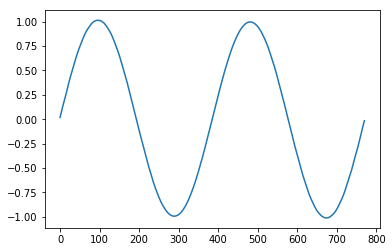

In [6]:
plt.plot(GMM_U)

In [7]:
GMM_Radius = rho(inputsize,A1.to_full(),4*np.transpose(R),R,w,s)
print('GMM_Radius = {}'.format(GMM_Radius))

GMM_Radius = 0.6960837707866774


Local DMM on fine grid

In [8]:
Rnew, wnew, Rhoold, Rhonew, Radius = homotopy_optimizer_GD(inputsize, A0, A1.to_full(), R,  2/3, s, learning_rate = 1e-5,accept_radius = 1 ,step_length = 1e-3, lam = np.zeros([1,outputsize]))

======Section 1======
L = 0.002
rho = 0.6769015961274206
L = 0.003
rho = 0.7093699082486895
L = 0.004
rho = 0.7960345839680388
L = 0.005
rho = 0.6785036843381844
L = 0.006
rho = 0.8261450938054861
L = 0.007
rho = 0.7175504182880875
L = 0.008
rho = 0.765084089821953
L = 0.009000000000000001
rho = 0.7117891765405497
L = 0.010000000000000002
rho = 0.7840547992105539
L = 0.011000000000000003
rho = 0.691081877590465
L = 0.012000000000000004
rho = 0.8874675800885709
L = 0.013000000000000005
rho = 0.787183815424166
L = 0.014000000000000005
rho = 0.6861057643719295
L = 0.015000000000000006
rho = 0.909701012708943
L = 0.016000000000000007
rho = 0.8199391126608213
L = 0.017000000000000008
rho = 0.7129806388061285
L = 0.01800000000000001
rho = 0.784543329668491
L = 0.01900000000000001
rho = 0.6907283166024113
L = 0.02000000000000001
rho = 0.894122074603798
L = 0.02100000000000001
rho = 0.7967604205246201
L = 0.022000000000000013
rho = 0.6787986211644184
L = 0.023000000000000013
rho = 0.8555981646

L = 0.1220000000000001
rho = 0.7275233155661767
L = 0.1230000000000001
rho = 0.7525285449213273
L = 0.1240000000000001
rho = 0.7249074562302543
L = 0.12500000000000008
rho = 0.7571467468727304
L = 0.12600000000000008
rho = 0.7211096770287672
L = 0.12700000000000009
rho = 0.7649277198056307
L = 0.12800000000000009
rho = 0.7145442742204442
L = 0.1290000000000001
rho = 0.7824073187055575
L = 0.1300000000000001
rho = 0.6956120103417053
L = 0.1310000000000001
rho = 0.8718220046585666
L = 0.1320000000000001
rho = 0.766815329519444
L = 0.1330000000000001
rho = 0.7128913661731253
L = 0.1340000000000001
rho = 0.7882935808339339
L = 0.1350000000000001
rho = 0.6861777881151143
L = 0.1360000000000001
rho = 0.9159590669287696
L = 0.1370000000000001
rho = 0.8288196499440087
L = 0.1380000000000001
rho = 0.7217865273939944
L = 0.1390000000000001
rho = 0.7639866825060557
L = 0.1400000000000001
rho = 0.716492330250948
L = 0.1410000000000001
rho = 0.7769884754092597
L = 0.1420000000000001
rho = 0.7035838

L = 0.2420000000000002
rho = 0.7152805986187979
L = 0.2430000000000002
rho = 0.7822981147693407
L = 0.2440000000000002
rho = 0.7009100942588714
L = 0.2450000000000002
rho = 0.8455658594355111
L = 0.2460000000000002
rho = 0.7356283140238369
L = 0.2470000000000002
rho = 0.7434138270688702
L = 0.2480000000000002
rho = 0.7360505231918146
L = 0.2490000000000002
rho = 0.7431542813351478
L = 0.25000000000000017
rho = 0.7360595410371602
L = 0.25100000000000017
rho = 0.7433138958674447
L = 0.25200000000000017
rho = 0.7358561816827771
L = 0.25300000000000017
rho = 0.7436733316892846
L = 0.25400000000000017
rho = 0.7355219402742355
L = 0.25500000000000017
rho = 0.7441613417849738
L = 0.25600000000000017
rho = 0.7350916002010044
L = 0.2570000000000002
rho = 0.7447549031977635
L = 0.2580000000000002
rho = 0.7345772106043024
L = 0.2590000000000002
rho = 0.7454525781395849
L = 0.2600000000000002
rho = 0.7339782541828956
L = 0.2610000000000002
rho = 0.7462657887970994
L = 0.2620000000000002
rho = 0.73

L = 0.36200000000000027
rho = 0.7071129435517501
L = 0.36300000000000027
rho = 0.8192371953809514
L = 0.36400000000000027
rho = 0.7045561721506187
L = 0.36500000000000027
rho = 0.8310051183678546
L = 0.36600000000000027
rho = 0.7170360232455373
L = 0.36700000000000027
rho = 0.7802968947299949
L = 0.36800000000000027
rho = 0.707464289319548
L = 0.36900000000000027
rho = 0.8174611309370619
L = 0.3700000000000003
rho = 0.7019665162664726
L = 0.3710000000000003
rho = 0.8443400268183603
L = 0.3720000000000003
rho = 0.7309930935686819
L = 0.3730000000000003
rho = 0.7514197713051816
L = 0.3740000000000003
rho = 0.7314650225269511
L = 0.3750000000000003
rho = 0.7518146396207882
L = 0.3760000000000003
rho = 0.7311513202281112
L = 0.3770000000000003
rho = 0.7527507902415335
L = 0.3780000000000003
rho = 0.7304737304510125
L = 0.3790000000000003
rho = 0.7540294402484882
L = 0.3800000000000003
rho = 0.7295396725976996
L = 0.3810000000000003
rho = 0.7556471659250932
L = 0.3820000000000003
rho = 0.72

L = 0.4820000000000004
rho = 0.7475919607171342
L = 0.4830000000000004
rho = 0.7378639209835913
L = 0.4840000000000004
rho = 0.7476358442798915
L = 0.4850000000000004
rho = 0.7378821805311496
L = 0.4860000000000004
rho = 0.7476742584771652
L = 0.4870000000000004
rho = 0.7379053104160612
L = 0.4880000000000004
rho = 0.7477070932058637
L = 0.4890000000000004
rho = 0.7379333985985294
L = 0.4900000000000004
rho = 0.7477342547557825
L = 0.4910000000000004
rho = 0.7379665193829698
L = 0.4920000000000004
rho = 0.7477556676892577
L = 0.4930000000000004
rho = 0.738004732168749
L = 0.4940000000000004
rho = 0.7477712766032205
L = 0.4950000000000004
rho = 0.7380480802128552
L = 0.4960000000000004
rho = 0.7477810477564267
L = 0.4970000000000004
rho = 0.7380965894319456
L = 0.4980000000000004
rho = 0.74778497053931
L = 0.4990000000000004
rho = 0.7381502672789156
L = 0.5000000000000003
rho = 0.7477830587604606
L = 0.5010000000000003
rho = 0.738209101720181
L = 0.5020000000000003
rho = 0.7477753517191

L = 0.6030000000000004
rho = 0.7436393231038825
L = 0.6040000000000004
rho = 0.7450889087787724
L = 0.6050000000000004
rho = 0.7437122236166411
L = 0.6060000000000004
rho = 0.7450781137282523
L = 0.6070000000000004
rho = 0.7437829636386051
L = 0.6080000000000004
rho = 0.7450695918724481
L = 0.6090000000000004
rho = 0.7438516102992682
L = 0.6100000000000004
rho = 0.745063265689091
L = 0.6110000000000004
rho = 0.7439182330901336
L = 0.6120000000000004
rho = 0.7450590562570854
L = 0.6130000000000004
rho = 0.7439829033393626
L = 0.6140000000000004
rho = 0.7450568837359445
L = 0.6150000000000004
rho = 0.7440456937226709
L = 0.6160000000000004
rho = 0.745056667806618
L = 0.6170000000000004
rho = 0.744106677808247
L = 0.6180000000000004
rho = 0.7450583280741996
L = 0.6190000000000004
rho = 0.7441659296389772
L = 0.6200000000000004
rho = 0.7450617844340375
L = 0.6210000000000004
rho = 0.7442235233463849
L = 0.6220000000000004
rho = 0.7450669574046032
L = 0.6230000000000004
rho = 0.744279532800

L = 0.7240000000000005
rho = 0.7463442721020784
L = 0.7250000000000005
rho = 0.7462299040300912
L = 0.7260000000000005
rho = 0.7463759297645185
L = 0.7270000000000005
rho = 0.7462629698669017
L = 0.7280000000000005
rho = 0.7464076382013742
L = 0.7290000000000005
rho = 0.7462960282171855
L = 0.7300000000000005
rho = 0.7464393949143654
L = 0.7310000000000005
rho = 0.7463290813120345
L = 0.7320000000000005
rho = 0.746471197632889
L = 0.7330000000000005
rho = 0.7463621311674584
L = 0.7340000000000005
rho = 0.7465030442933477
L = 0.7350000000000005
rho = 0.7463951796047141
L = 0.7360000000000005
rho = 0.7465349330208405
L = 0.7370000000000005
rho = 0.7464282282674868
L = 0.7380000000000005
rho = 0.7465668621116882
L = 0.7390000000000005
rho = 0.7464612786388501
L = 0.7400000000000005
rho = 0.7465988300182176
L = 0.7410000000000005
rho = 0.7464943320559948
L = 0.7420000000000005
rho = 0.7466308353331308
L = 0.7430000000000005
rho = 0.7465273897240338
L = 0.7440000000000005
rho = 0.7466628767

L = 0.8450000000000006
rho = 0.7482293590717438
L = 0.8460000000000006
rho = 0.7483324564179811
L = 0.8470000000000006
rho = 0.7482631141564425
L = 0.8480000000000006
rho = 0.7483657825530191
L = 0.8490000000000006
rho = 0.7482968848473148
L = 0.8500000000000006
rho = 0.7483991292950456
L = 0.8510000000000006
rho = 0.7483306711635225
L = 0.8520000000000006
rho = 0.7484324965740248
L = 0.8530000000000006
rho = 0.748364473122913
L = 0.8540000000000006
rho = 0.7484658843210131
L = 0.8550000000000006
rho = 0.7483982907434983
L = 0.8560000000000006
rho = 0.748499292468671
L = 0.8570000000000007
rho = 0.7484321240423724
L = 0.8580000000000007
rho = 0.748532720951997
L = 0.8590000000000007
rho = 0.7484659730361599
L = 0.8600000000000007
rho = 0.748566169706427
L = 0.8610000000000007
rho = 0.7484998377410834
L = 0.8620000000000007
rho = 0.7485996386699879
L = 0.8630000000000007
rho = 0.7485337181725701
L = 0.8640000000000007
rho = 0.7486331277818136
L = 0.8650000000000007
rho = 0.7485676143464

L = 0.9660000000000007
rho = 0.7503667327168012
L = 0.9670000000000007
rho = 0.7503174839165285
L = 0.9680000000000007
rho = 0.7504012132207932
L = 0.9690000000000007
rho = 0.7503522152270529
L = 0.9700000000000008
rho = 0.7504357121119587
L = 0.9710000000000008
rho = 0.7503869628927066
L = 0.9720000000000008
rho = 0.7504702293764998
L = 0.9730000000000008
rho = 0.7504217269253225
L = 0.9740000000000008
rho = 0.7505047650011375
L = 0.9750000000000008
rho = 0.7504565073371458
L = 0.9760000000000008
rho = 0.7505393189732176
L = 0.9770000000000008
rho = 0.7504913041389939
L = 0.9780000000000008
rho = 0.7505738912801614
L = 0.9790000000000008
rho = 0.7505261173436277
L = 0.9800000000000008
rho = 0.7506084819103855
L = 0.9810000000000008
rho = 0.750560946962523
L = 0.9820000000000008
rho = 0.7506430908525269
L = 0.9830000000000008
rho = 0.7505957930078155
L = 0.9840000000000008
rho = 0.7506777180955098
L = 0.9850000000000008
rho = 0.750630655491664
L = 0.9860000000000008
rho = 0.75071236362

In [9]:
GLOBALR = Rnew

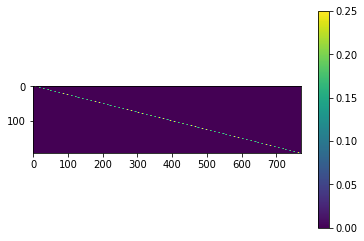

In [10]:
plt.imshow(GLOBALR)
plt.colorbar()

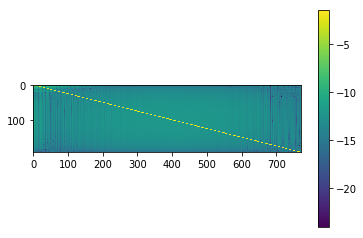

In [11]:
plt.imshow(np.log(np.abs(GLOBALR)))
plt.colorbar()

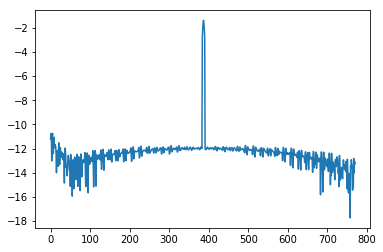

In [12]:
plt.plot(np.log(np.abs(GLOBALR[int(outputsize/2)][:])))

Energy norm: 
0.3949949561698868
L2 norm: 
0.015048319248315468
H1 norm: 
0.2875339443751664
Energy norm: 
0.03143304871401065
L2 norm: 
0.021281537171887834
H1 norm: 
0.03225731979800806
0.7509553937175633


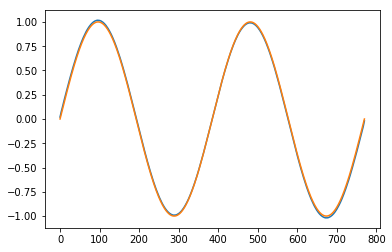

In [13]:
Xfine = np.linspace(0,1,inputsize)
Xcoarse = np.linspace(0,1,outputsize)
Mediafine = a(Xfine)
Mediacoarse = a(Xcoarse)
Urealfine = u_real(Xfine).reshape([inputsize,1])
Urealcoarse = u_real(Xcoarse).reshape([outputsize,1])
GLOBALA = np.zeros([outputsize,outputsize])

for i in range(outputsize):
    for j in range(outputsize):
        basisi = GLOBALR[i][:]
        basisj = GLOBALR[j][:]
        gxbasisi = np.gradient(basisi,h)
        gxbasisj = np.gradient(basisj,h)
        GLOBALA[i][j] = (np.sum(Mediafine*gxbasisi*gxbasisj))*(H)
        
GLOBALF = np.zeros([outputsize,1])
F = rightf(Xfine)
for j in range(outputsize):
        basisj = GLOBALR[j][:]
        GLOBALF[j][0] = (np.sum(F*basisj))*(H)
        
GLOBALU = np.linalg.solve(GLOBALA,GLOBALF)
GlobalU = np.zeros([inputsize,1])
for i in range(outputsize):
    GlobalU = GlobalU + GLOBALU[i]*GLOBALR[i][:].reshape([inputsize,1])
    
deltaU = GlobalU - Urealfine    
Mediafine = a(np.linspace(0,1,inputsize-1)).reshape([inputsize-1,1])
energynorm = np.sqrt(np.sum(np.multiply(np.multiply(np.diff(Urealfine,axis=0)/h,np.diff(Urealfine,axis=0)/h),Mediafine)*(h)))
l2norm = np.sqrt((np.sum((Urealfine)**2)*(h)))
h1norm = np.sqrt((np.sum((Urealfine)**2)*(h))+(np.sum((np.diff(Urealfine,axis=0)/h)**2)*(h)))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.diff(deltaU,axis=0)/h,np.diff(deltaU,axis=0)/h),Mediafine)*(h))))
print('L2 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h))))
print('H1 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h))+(np.sum((np.diff(deltaU,axis=0)/h)**2)*(h))))


print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.diff(deltaU,axis=0)/h,np.diff(deltaU,axis=0)/h),Mediafine)*(h)))/energynorm)
print('L2 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h)))/l2norm)
print('H1 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h))+(np.sum((np.diff(deltaU,axis=0)/h)**2)*(h)))/h1norm)
print(Rhonew)

plt.plot(GlobalU)
plt.plot(Urealfine)